In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
train_data = np.load("train_data_encode.npy")
train_labels = np.load("train_labels.npy")
test_data = np.load("test_data_encode.npy")
test_labels = np.load("test_labels.npy")

In [3]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=101)

In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.callbacks import EarlyStopping

In [5]:
cnn_model = Sequential()

cnn_model.add(Conv1D(128, kernel_size = 5, activation = 'relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_model.add(MaxPooling1D(pool_size = 2, padding='same'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv1D(64, kernel_size = 5, activation = 'relu', padding='same'))
cnn_model.add(MaxPooling1D(pool_size = 2, padding='same'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv1D(32, kernel_size = 5, activation = 'relu', padding='same'))
cnn_model.add(MaxPooling1D(pool_size = 2, padding='same'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv1D(16, kernel_size = 5, activation = 'relu', padding='same'))
cnn_model.add(MaxPooling1D(pool_size = 2, padding='same'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())

cnn_model.add(Dense(units = 128, activation = 'relu'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(units = 1, activation = 'sigmoid' ))

In [6]:
callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min')
cnn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 41, 128)           13568     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 21, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 21, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 64)            41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 64)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 64)            0

In [7]:
H = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100, verbose=1,callbacks=[callback])

Epoch 1/100
60/60 [==============================] - 4s 19ms/step - loss: 0.6940 - accuracy: 0.5139 - val_loss: 0.6937 - val_accuracy: 0.4864
Epoch 2/100
60/60 [==============================] - 1s 12ms/step - loss: 0.6934 - accuracy: 0.5118 - val_loss: 0.6924 - val_accuracy: 0.5388
Epoch 3/100
60/60 [==============================] - 1s 13ms/step - loss: 0.6921 - accuracy: 0.5181 - val_loss: 0.6911 - val_accuracy: 0.5702
Epoch 4/100
60/60 [==============================] - 1s 13ms/step - loss: 0.6901 - accuracy: 0.5417 - val_loss: 0.6904 - val_accuracy: 0.5262
Epoch 5/100
60/60 [==============================] - 1s 13ms/step - loss: 0.6871 - accuracy: 0.5533 - val_loss: 0.6828 - val_accuracy: 0.6562
Epoch 6/100
60/60 [==============================] - 1s 12ms/step - loss: 0.6771 - accuracy: 0.6152 - val_loss: 0.6721 - val_accuracy: 0.6520
Epoch 7/100
60/60 [==============================] - 1s 13ms/step - loss: 0.6550 - accuracy: 0.6525 - val_loss: 0.6449 - val_accuracy: 0.6499
Epoch 

In [10]:
cnn_prediction = cnn_model.predict(test_data)
cnn_pred = [i[0] for i in cnn_prediction]

In [28]:
import sklearn.metrics as mt
import matplotlib.pyplot as plt
import numpy as np

def draw_roc(preds):
    for i in range(len(preds)):
        fpr, tpr, _ = mt.roc_curve(test_labels,  preds[i])
        auc = mt.roc_auc_score(test_labels, preds[i])
        plt.plot(fpr,tpr,label="auc={}".format(str(auc)))
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        print('Best Threshold_%d=%f, G-Mean=%.3f' % (i, _[ix], gmeans[ix]))
    plt.legend(loc=4)
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.show()

Best Threshold_0=0.426782, G-Mean=0.652


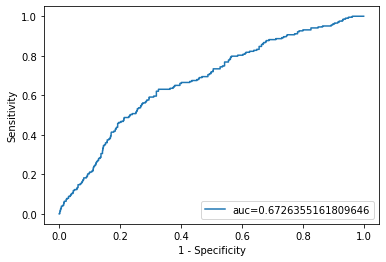

In [29]:
draw_roc([cnn_pred])

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef, confusion_matrix, accuracy_score

In [8]:
def evaluate(pred):
    print("Confusion matrix\n", confusion_matrix(pred, test_labels))
    print("MCC: ", matthews_corrcoef(pred, test_labels))
    tn, fp, fn, tp = confusion_matrix(pred, test_labels).ravel()
    tpr = tp/(tp + fn)
    print("Recall/Sensitivity: ", tpr)
    tnr = tn/(tn + fp)
    print("Specificity: ", tnr)
    print("Accuracy: ", accuracy_score(pred, test_labels))
    print("\n")

In [20]:
p_ = []
for i in cnn_pred:
    if i >= 0.5:
        p_.append(1)
    else:
        p_.append(0)
p_ = np.array(p_)

In [21]:
evaluate(p_)

Confusion matrix
 [[707  83]
 [315 120]]
MCC:  0.2198211451500875
Recall/Sensitivity:  0.27586206896551724
Specificity:  0.8949367088607595
Accuracy:  0.6751020408163265


